# Linear Model Selection and Regularization

In [1]:
import pandas as pd
import random
import math
import operator
import numpy as np
import scipy as sc
from IPython.display import display, HTML

In [2]:
# Statsmodel
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.formula.api as smf

# Modelling
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

# Evaluation Metric
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error

# Regularization
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV

# Resampling
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.model_selection import GridSearchCV


/Users/ando/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns
from matplotlib import gridspec

%matplotlib inline
plt.style.use('smandry')

In [4]:
# Extend linear_model.LinearRegression to calculate stats
class LinearRegression(linear_model.LinearRegression):
    def __init__(self,*args,**kwargs):
        """
        Linear Regression with Stats output
        """
        super(LinearRegression,self).__init__(*args,**kwargs)

    def fit_stats(self,X,y):
        """ 
        X is a dataFrame
        
        """
        self.fit(X,y)
        self.params = np.append(self.intercept_,self.coef_)
        predictions = self.predict(X)
        newX = pd.DataFrame({"Constant":np.ones(len(X))}).join(pd.DataFrame(X.reset_index(drop=True))) 
        n_obs = len(newX)
        n_pred = len(newX.columns)-1        
        RSS = sum((y-predictions)**2)
        mean_y = y.mean()
        TSS = sum((y - mean_y)**2)
        MSE = (RSS)/float(n_obs-n_pred)
        self.MSE = MSE
        variance = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
        self.StdErr = np.sqrt(variance)
        self.tValues = self.params/self.StdErr
        self.pValues =[2*(1 - sc.stats.t.cdf(np.abs(i),(len(newX)-1))) for i in self.tValues]
        self.confInt = [self.params-1.95996398*self.StdErr, self.params+1.95996398*self.StdErr]
        self.rsquare = 1.0 - (RSS/TSS)
        self.rsquare_adj = 1.0 -((RSS/TSS)*((n_obs-1)/float(n_obs-n_pred-1)))
        
        myDF3 = pd.DataFrame(index=newX.columns)
        myDF3["Coefs"],myDF3["StdErr"],myDF3["tValues"],myDF3["pValue"] = [self.params,self.StdErr,self.tValues,self.pValues]
        myDF3["[0.025"] = self.confInt[0]
        myDF3["0.0975]"] = self.confInt[1]
        self.results = myDF3
        

# Subset selection

In [5]:
# Using linear regression
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_out = 0.05, 
                       verbose=True):
    """ 
    Must add a method to calculate statistical parameter in linear_model.LinearRegression 
    Use Above extension LinearRegression()
    Perform a forward-backward Hybrid approach feature selection 
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    selected = list(initial_list)
    best_rsquared = 0.0
    reg = LinearRegression()
    while True:
        changed=False
        # forward step
        remaining = list(set(X.columns)-set(selected))
        new_rsquared = pd.Series(index=remaining)
        for candidate in remaining:
            reg.fit_stats(X[selected+[candidate]], y)
            new_rsquared[candidate] = reg.rsquare_adj
        current_rsquared = new_rsquared.max()
        if current_rsquared > best_rsquared:
            best_feature = new_rsquared.argmax()
            selected.append(best_feature)
            best_rsquared = current_rsquared
            changed=True
            if verbose:
                print('Added feature: {:30} with Rsquared {:.6}'.format(best_feature, current_rsquared))
        # backward step
        reg.fit_stats(X[selected],y)        
        # use all coefs except intercept
        pvalues = reg.results.iloc[1:].pValue.values
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            worst_feature = selected[pvalues.argmax()]
            selected.remove(worst_feature)
            changed=True
            if verbose:
                print('\nDropped {:37} with PValues of {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            print "Final model"
            reg.fit_stats(X[selected],y)
            display(reg.results)
            if verbose:
                print
                print('Selected feature: ["{}"]'.format('", "'.join(selected)))
            break
    return selected

## Using statsmodel
def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
            print('Added feature: {:30} with Rsquared {:.6}'.format(best_candidate, best_new_score))
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model


In [6]:
# Load datasets and encode Categorical variables
Credit = pd.read_csv('/Users/ando/andry/ML/courses/Statistics/Intro_to_Stat_learning/data/Credit.csv', index_col=[0])
Credit['genderI']= Credit['Gender'].map({' Male':0, 'Female':1})
Credit = pd.get_dummies(Credit, columns=['Student','Ethnicity','Married'], drop_first=True)

In [ ]:
# Data input
Credit[list(set(Credit.columns)-set(['Gender','Balance']))].head(2)

In [12]:
Best_features = stepwise_selection(Credit[list(set(Credit.columns)-set(['Gender','Balance']))], Credit.Balance, threshold_out=0.05)

Added feature: Rating                         with Rsquared 0.74521
Added feature: Income                         with Rsquared 0.874489
Added feature: Student_Yes                    with Rsquared 0.949499
Added feature: Limit                          with Rsquared 0.951703
Added feature: Cards                          with Rsquared 0.953579
Added feature: Age                            with Rsquared 0.953996
Added feature: genderI                        with Rsquared 0.95401

Dropped genderI                               with PValues of 0.290543
Final model


,Coefs,StdErr,tValues,pValue,[0.025,0.0975]
Constant,-493.734187,24.793241,-19.914064,0.000000e+00,-542.328047,-445.140328
Rating,1.091187,0.484188,2.253642,2.476082e-02,0.142196,2.040179
Income,-7.795082,0.233121,-33.437940,0.000000e+00,-8.251991,-7.338174
Student_Yes,425.609937,16.488600,25.812375,0.000000e+00,393.292874,457.926999
Limit,0.193691,0.032341,5.988949,4.716019e-09,0.130303,0.257080
Cards,18.211898,4.313166,4.222397,2.996511e-05,9.758248,26.665547
Age,-0.624056,0.291446,-2.141240,3.285988e-02,-1.195280,-0.052832



Selected feature: ["Rating", "Income", "Student_Yes", "Limit", "Cards", "Age"]


In [13]:
mmm = forward_selected(Credit[list(set(Credit.columns)-set(['Gender']))], 'Balance')

Added feature: Rating                         with Rsquared 0.74521
Added feature: Income                         with Rsquared 0.874489
Added feature: Student_Yes                    with Rsquared 0.949499
Added feature: Limit                          with Rsquared 0.951703
Added feature: Cards                          with Rsquared 0.953579
Added feature: Age                            with Rsquared 0.953996
Added feature: genderI                        with Rsquared 0.95401


# Shrinkage or regularisation method

## Ridge regression

In [7]:
# Scale all variables before regularization
scaler = preprocessing.StandardScaler()
newCr = Credit.loc[:,Credit.columns != 'Gender'].copy()
for Xin in newCr.columns:
    if Xin != 'Balance':
        newCr[Xin] = scaler.fit_transform(newCr[[Xin]])

In [8]:
# calculate l2 norm
def el_norm(X):
    return np.sqrt(sum(X**2))

# Ridge regression model
ridge = linear_model.Ridge()
coefs = []
norm_ridge = []
alphas = 10**np.linspace(10,-2,100)*0.5
cols = list(set(newCr.columns)-set(['Balance']))
mydf= pd.DataFrame(columns=cols)
for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(newCr[cols], newCr['Balance'])
    mydf = mydf.append(dict(zip(cols,ridge.coef_)),ignore_index=True)

# l2 norm for ridge model
norm_ridge = np.zeros(mydf.shape[0])
for i in range(mydf.shape[0]):
    norm_ridge[i] = el_norm(mydf.iloc[[i]].values[0])

# l2 norm for linear model
reglinear = linear_model.LinearRegression()
reglinear.fit(newCr.loc[:,newCr.columns != 'Balance'], newCr['Balance'])
norm_reg = el_norm(reglinear.coef_)

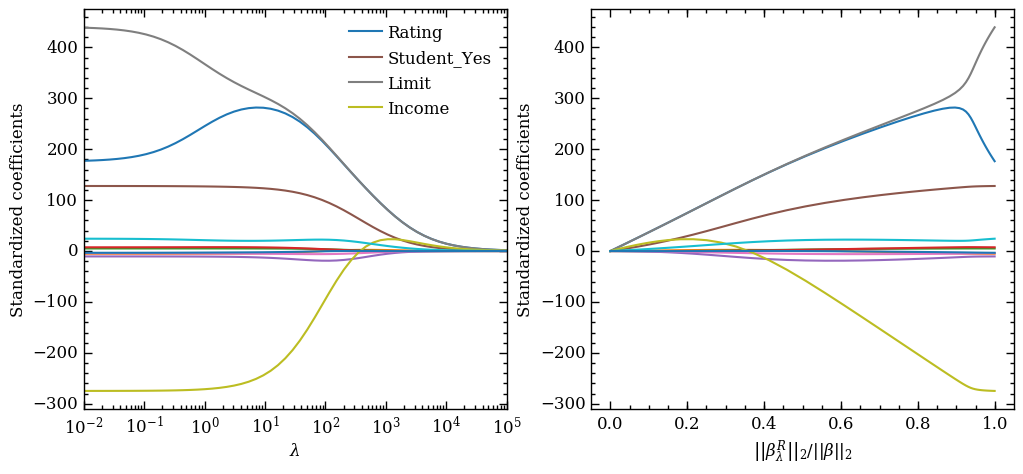

In [9]:
fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(12,5))
for col in cols:
    ax1.plot(alphas, mydf[col].values, label=col if mydf[col].abs().values[-1] > 100 else None)
    ax2.plot(norm_ridge/norm_reg, mydf[col].values)
ax1.legend(loc=1,fontsize ="medium")
ax1.set_xscale('log')
ax1.set_xlabel(r'$\lambda$')
ax1.set_ylabel('Standardized coefficients')
ax1.set_xlim((0.01,1e5))
ax2.set_xlabel(r'$\left \| \left \| \beta^{R}_{\lambda}\right \| \right \|_{2}/\left \| \left \| \beta \right \| \right \|_2$')
ax2.set_ylabel('Standardized coefficients')
plt.show()

# Lasso regularization

In [17]:
lasso = linear_model.Lasso()
coefs = []
norm_ridge = []
#alphas = 10**np.linspace(10,-2,100)*0.5
alphas = np.logspace(-2, 10, num=100)
cols = list(set(newCr.columns)-set(['Balance']))
mydf1= pd.DataFrame(columns=cols)
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(newCr[cols], newCr['Balance'])
    mydf1 = mydf1.append(dict(zip(cols,lasso.coef_)),ignore_index=True)

# l2 norm for ridge model
norm_lasso = np.zeros(mydf1.shape[0])
for i in range(mydf1.shape[0]):
    norm_lasso[i] = el_norm(mydf1.iloc[[i]].values[0])

# l2 norm for linear model
reglinear = linear_model.LinearRegression()
reglinear.fit(newCr.loc[:,newCr.columns != 'Balance'], newCr['Balance'])
norm_reg = el_norm(reglinear.coef_)

/Users/ando/anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


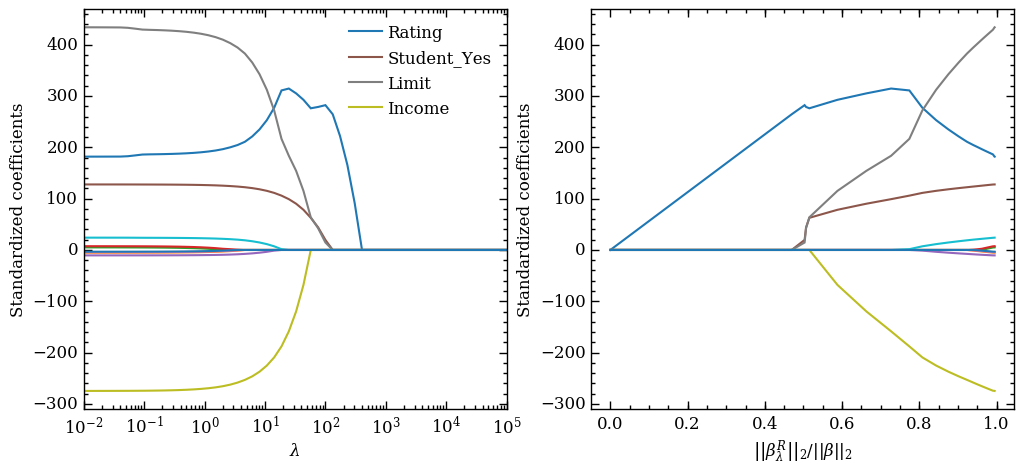

In [18]:
fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(12,5))
for col in cols:
    ax1.plot(alphas, mydf1[col].values, label=col if mydf1[col].abs().values[0] > 100 else None)
    ax2.plot(norm_lasso/norm_reg, mydf1[col].values)
ax1.legend(loc=1,fontsize ="medium")
ax1.set_xscale('log')
ax1.set_xlabel(r'$\lambda$')
ax1.set_ylabel('Standardized coefficients')
ax1.set_xlim((0.01,1e5))
ax2.set_xlabel(r'$\left \| \left \| \beta^{R}_{\lambda}\right \| \right \|_{2}/\left \| \left \| \beta \right \| \right \|_2$')
ax2.set_ylabel('Standardized coefficients')
plt.show()

## Selecting tuning parameter 

### Ridge with LOO cross-validation

In [10]:
# CV=None means LOO cross-validation
ridgeCV = linear_model.RidgeCV(cv=None, store_cv_values=True)
alphas = np.logspace(-4, 2, num=20)
cols = list(set(newCr.columns)-set(['Balance']))
mydf2 = pd.DataFrame(columns=cols)
rss = np.array([])

for a in alphas:
    ridgeCV.set_params(alphas=[a])
    ridgeCV.fit(newCr[cols], newCr['Balance'])
    mse = ridgeCV.cv_values_[:,0].sum()/(400.0**2)
    rss = np.append(rss, mse)
    mydf2 = mydf2.append(dict(zip(cols,ridgeCV.coef_)),ignore_index=True)


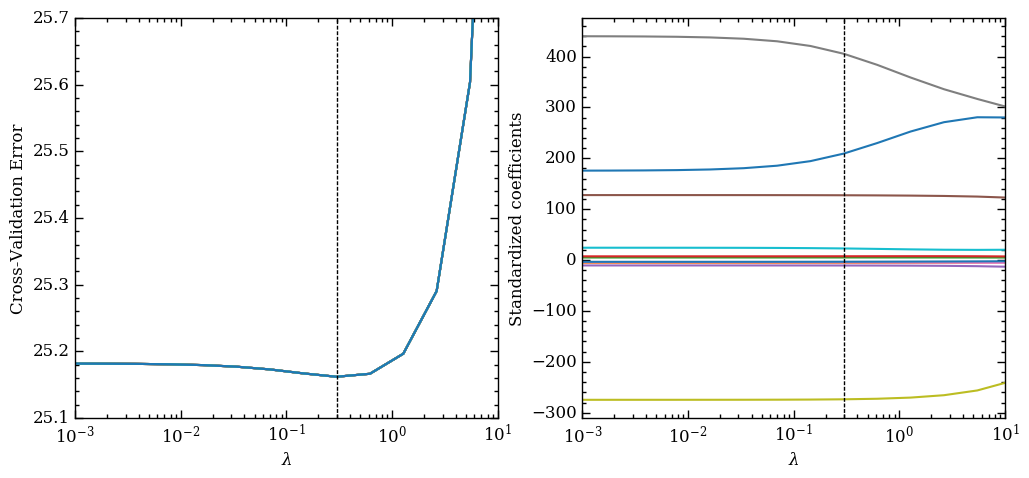

In [11]:
fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(12,5))
for col in cols:
    ax2.plot(alphas, mydf2[col].values, label=col if mydf2[col].abs().values[0] > 100 else None)
    ax1.plot(alphas, rss)
indmax = rss.argmin()
ax1.axvline(alphas[indmax], color='k', ls='dashed', lw=1)
ax2.axvline(alphas[indmax], color='k', ls='dashed', lw=1)
ax1.legend(loc=1,fontsize ="medium")
ax1.set_xlim((1e-3,10))
ax1.set_ylim((25.1,25.7))
ax2.set_xlim((1e-3,10))

ax1.set_xscale('log')
ax1.set_xlabel(r'$\lambda$')
ax1.set_ylabel('Cross-Validation Error')
ax2.set_xlabel(r'$\lambda$')
ax2.set_ylabel('Standardized coefficients')
ax2.set_xscale('log')
plt.show()

## Principal components regression

In [79]:
reg = linear_model.LinearRegression()
mydf2 = pd.DataFrame(columns=cols)
rss = np.array([])
rsstest = np.array([])
pca = PCA()
for i in range(11):
    pca.set_params(n_components=i+1)
    X_reduced = pca.fit_transform(newCr[cols])
    clf = GridSearchCV(estimator=reg, cv=10, param_grid={'n_jobs':[-1]})
    clf.fit(X_reduced, newCr['Balance'])
    pred = clf.predict(X_reduced)
    mse = ((newCr['Balance'] - pred)**2).sum()/float(len(X_reduced))
    rss = np.append(rss, mse)
    # or just use cross_validate to get test_error
    cv_results = cross_validate(reg, X_reduced, newCr['Balance'],  cv=10, scoring=('neg_mean_squared_error'))
    rsstest = np.append(rsstest, -cv_results['test_score'].mean())
    mydf2 = mydf2.append(dict(zip(cols,clf.best_estimator_.coef_)),ignore_index=True)


In [82]:
mydf2.fillna(0, inplace=True)

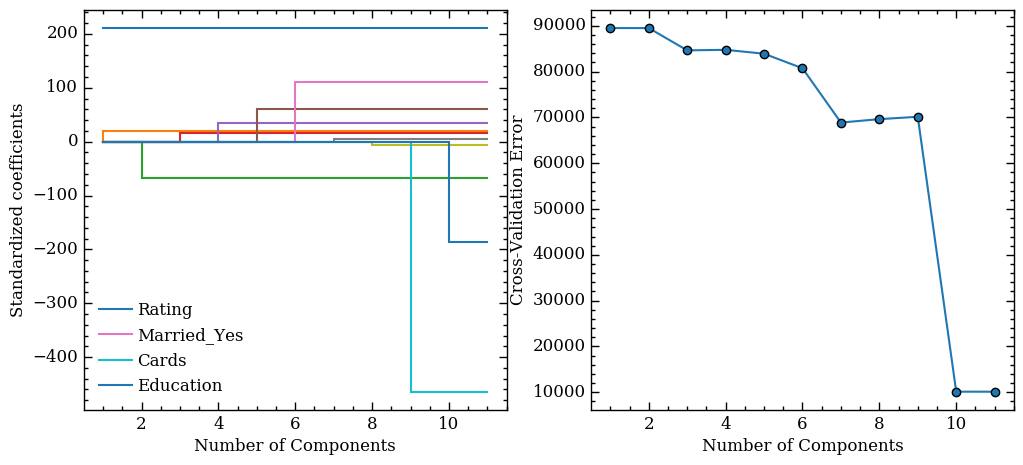

In [83]:
fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(12,5))
npoly=np.arange(11)+1
for col in cols:
    ax1.step(npoly, mydf2[col].values, label=col if mydf2[col].abs().values[10] > 100 else None)

ax1.legend(fontsize ="medium")
ax2.plot(npoly, rsstest, 'o-')
ax1.set_xlabel(r'Number of Components')
ax2.set_ylabel('Cross-Validation Error')
ax2.set_xlabel(r'Number of Components')
ax1.set_ylabel('Standardized coefficients')
plt.show()

In [53]:
from sklearn.model_selection import cross_validate

# Lab1: Subset selection models

## Best subset collection

In [113]:
Hitters = pd.read_csv('Data/Hitters.csv', index_col=0)
object_type = Hitters.columns[Hitters.dtypes == object].values
Hitters = pd.get_dummies(Hitters, columns=object_type, drop_first=True)
# Dropping NaN
Hitters.dropna(inplace=True)

In [114]:
Hitters.head(2)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,League_N,Division_W,NewLeague_N
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10,475.0,1,1,1
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14,480.0,0,1,0


In [115]:
Hitters.describe()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,League_N,Division_W,NewLeague_N
count,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000
mean,403.642586,107.828897,11.619772,54.745247,51.486692,41.114068,7.311787,2657.543726,722.186312,69.239544,361.220532,330.418251,260.266160,290.711027,118.760456,8.593156,535.925882,0.471483,0.509506,0.463878
std,147.307209,45.125326,8.757108,25.539816,25.882714,21.718056,4.793616,2286.582929,648.199644,82.197581,331.198571,323.367668,264.055868,279.934575,145.080577,6.606574,451.118681,0.500138,0.500863,0.499644
min,19.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,19.000000,4.000000,0.000000,2.000000,3.000000,1.000000,0.000000,0.000000,0.000000,67.500000,0.000000,0.000000,0.000000
25%,282.500000,71.500000,5.000000,33.500000,30.000000,23.000000,4.000000,842.500000,212.000000,15.000000,105.500000,95.000000,71.000000,113.500000,8.000000,3.000000,190.000000,0.000000,0.000000,0.000000
50%,413.000000,103.000000,9.000000,52.000000,47.000000,37.000000,6.000000,1931.000000,516.000000,40.000000,250.000000,230.000000,174.000000,224.000000,45.000000,7.000000,425.000000,0.000000,1.000000,0.000000
75%,526.000000,141.500000,18.000000,73.000000,71.000000,57.000000,10.000000,3890.500000,1054.000000,92.500000,497.500000,424.500000,328.500000,322.500000,192.000000,13.000000,750.000000,1.000000,1.000000,1.000000
max,687.000000,238.000000,40.000000,130.000000,121.000000,105.000000,24.000000,14053.000000,4256.000000,548.000000,2165.000000,1659.000000,1566.000000,1377.000000,492.000000,32.000000,2460.000000,1.000000,1.000000,1.000000


In [240]:
def test_cv(estimator, X, y):
    lst = xrange(X.shape[1])
    best = []
    for i in xrange(1, 5):
        best_score = np.inf
        best_subset = None
        els = [list(x) for x in combinations(lst, i)]
        for subset in els:
            estimator.fit(X.iloc[:, subset], y)
            pred = estimator.predict(X.iloc[:, subset])
            score = ((y-pred)**2).sum()
            if score < best_score:
                best_score, best_subset = score, subset
        best.append([best_score, best_subset])
    return best_subset, best_score , best  

In [241]:
test_cv(reg, Hitters.loc[:, Hitters.columns != 'Salary'], Hitters['Salary'])

([1, 11, 13, 17],
 27970851.815816257,
 [[36179679.25504184, [11]],
  [30646559.890372835, [1, 11]],
  [29249296.855867323, [1, 11, 13]],
  [27970851.815816257, [1, 11, 13, 17]]])

In [246]:
#  Best subsets
[Hitters.columns[x] for x in [1, 11, 13, 17]]

['Hits', 'CRBI', 'PutOuts', 'League_N']

In [248]:
Hitters.columns

Index([u'AtBat', u'Hits', u'HmRun', u'Runs', u'RBI', u'Walks', u'Years',
       u'CAtBat', u'CHits', u'CHmRun', u'CRuns', u'CRBI', u'CWalks',
       u'PutOuts', u'Assists', u'Errors', u'Salary', u'League_N',
       u'Division_W', u'NewLeague_N'],
      dtype='object')

In [251]:
# Best 6 subsets 
sub6 = ['AtBat', 'Hits', 'Walks','CRBI', 'Division_W','PutOuts']
reg.fit(Hitters[sub6], Hitters['Salary'])
reg.coef_

array([  -1.86858923,    7.60439763,    3.69764677,    0.64301694,
       -122.95153377,    0.26430761])

## Forward and Backward Stepwise selection

In [252]:
Best_features = stepwise_selection(Hitters.loc[:, Hitters.columns != 'Salary'], Hitters['Salary'], threshold_out=0.05)

Added feature: CRBI                           with Rsquared 0.31885
Added feature: Hits                           with Rsquared 0.420802
Added feature: PutOuts                        with Rsquared 0.445075
Added feature: Division_W                     with Rsquared 0.467273
Added feature: AtBat                          with Rsquared 0.480897
Added feature: Walks                          with Rsquared 0.4972
Added feature: CWalks                         with Rsquared 0.499866

Dropped CWalks                                with PValues of 0.124576
Final model


,Coefs,StdErr,tValues,pValue,[0.025,0.0975]
Constant,91.511798,64.873481,1.410620,0.159543,-35.637887,218.661483
CRBI,0.643017,0.064309,9.998903,0.000000,0.516974,0.769060
Hits,7.604398,1.659306,4.582877,0.000007,4.352217,10.856578
PutOuts,0.264308,0.074626,3.541748,0.000470,0.118043,0.410573
Division_W,-122.951534,39.742745,-3.093685,0.002191,-200.845883,-45.057185
AtBat,-1.868589,0.526395,-3.549786,0.000457,-2.900304,-0.836874
Walks,3.697647,1.207999,3.060968,0.002436,1.330012,6.065281



Selected feature: ["CRBI", "Hits", "PutOuts", "Division_W", "AtBat", "Walks"]


## Valdation and Cross-Validation sets

In [254]:
from sklearn.model_selection import train_test_split

In [255]:
Xtrain, Xtest, ytrain, ytest = train_test_split(Hitters.loc[:, Hitters.columns != 'Salary'], Hitters['Salary'], test_size=0.1,random_state=1)